<a href="https://colab.research.google.com/github/buganart/BUGAN/blob/master/script_GAN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive
from google.colab import output
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#right click shared folder IRCMS_GAN_collaborative_database and "Add shortcut to Drive" to My drive
%cd drive/My Drive/IRCMS_GAN_collaborative_database/

#record paths to resources
data_path = "Research/Peter/Tree_3D_models_obj/obj_files/"
run_path = "Experiments/colab-treegan/"

# !ls

/content/drive/.shortcut-targets-by-id/1ylB2p6N0qQ-G4OsBuwcZ9C0tsqVu9ww4/IRCMS_GAN_collaborative_database


In [3]:
# Install dependencies - OSMesa, mmatl's fork of PyOpenGL
!sudo apt update
!sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
!sudo dpkg -i ./mesa_18.3.3-0.deb || true
!sudo apt install -f
!git clone https://github.com/mmatl/pyopengl.git
!pip install ./pyopengl

!pip install trimesh
# !pip install meshrender==0.0.1
# !pip install autolab_perception
!pip install wandb -q
output.clear()

#add libraries, and login to wandb

In [4]:
import io
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import trimesh
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

In [5]:
!wandb login
output.clear()

In [6]:
#id None to start a new run. For resuming run, put the id of the run below
id = "r968ai0b"
resume = False
if id is None:
    id = wandb.util.generate_id()
else:
    resume = True

run = wandb.init(project="tree-gan", id=id, resume="allow", dir=run_path)
print("run id:" + str(wandb.run.id))
wandb.run.name = str(wandb.run.id)
wandb.watch_called = False
wandb.run.save_code = False

run id:r968ai0b


Streaming file created twice in same run: Experiments/colab-treegan/wandb/run-20200812_132707-r968ai0b/wandb-history.jsonl
Streaming file created twice in same run: Experiments/colab-treegan/wandb/run-20200812_132707-r968ai0b/wandb-events.jsonl


In [7]:
#keep track of hyperparams
config = wandb.config
config.batch_size = 4
config.epochs = 1000
config.g_lr = 0.0001
config.g_layer = 2
config.d_lr = 0.00003           
config.d_layer = 1
config.seed = 1234
config.log_interval = 20
config.data_augmentation = True

#model description

In [8]:
#input: 128-d noise vector
#output: (250,250,250) array with values in [0,1]

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc_channel = 8 #16
        self.fc_size = 4

        num_unit1 = self.fc_channel   
        num_unit2 = 32   #32
        num_unit3 = 32   #64
        num_unit4 = 64   #128
        num_unit5 = 128   #256
        num_unit6 = 128   #512
        self.gen_fc = nn.Linear(128, num_unit1 * self.fc_size * self.fc_size * self.fc_size)
        self.gen = nn.Sequential(

            nn.ConvTranspose3d(num_unit1, num_unit2, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit2),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit2, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit3, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit3, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='trilinear'),


            nn.ConvTranspose3d(num_unit3, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit4, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit4, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit4, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='trilinear'),


            nn.ConvTranspose3d(num_unit4, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit5, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit5, num_unit6, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit6),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit6, num_unit6, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit6),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='trilinear'),

            nn.ConvTranspose3d(num_unit6, num_unit6, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit6),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit6, num_unit6, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit6),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit6, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit5, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2, mode='trilinear'),

            nn.ConvTranspose3d(num_unit5, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit4, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit3, num_unit2, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit2),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit2, num_unit1, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit1),
            nn.ReLU(True),
            nn.ConvTranspose3d(num_unit1, 1, 3, 1, padding = 1),
            nn.Sigmoid()                #tanh: voxel representation [-1,1], sigmoid: [0,1]
        )

    def forward(self, x):

        x = self.gen_fc(x)
        x = x.view(x.shape[0], self.fc_channel, self.fc_size, self.fc_size, self.fc_size)
        x = self.gen(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        num_unit1 = 8   #16
        num_unit2 = 16   #32
        num_unit3 = 32   #64
        num_unit4 = 32  #128
        num_unit5 = 64   #256
        num_unit6 = 64   #512
        
        self.dis = nn.Sequential(
            nn.Conv3d(1, num_unit1, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit1),
            nn.ReLU(True),
            nn.Conv3d(num_unit1, num_unit2, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit2),
            nn.ReLU(True),
            nn.Conv3d(num_unit2, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),

            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(num_unit3, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),
            nn.Conv3d(num_unit3, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),

            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(num_unit4, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),
            nn.Conv3d(num_unit5, num_unit5, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit5),
            nn.ReLU(True),
            nn.Conv3d(num_unit5, num_unit4, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit4),
            nn.ReLU(True),

            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(num_unit4, num_unit3, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit3),
            nn.ReLU(True),            
            nn.Conv3d(num_unit3, num_unit2, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit2),
            nn.ReLU(True),

            nn.MaxPool3d((2, 2, 2)),


            nn.Conv3d(num_unit2, num_unit1, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit1),
            nn.ReLU(True),
            nn.Conv3d(num_unit1, num_unit1, 3, 1, padding = 1),
            nn.BatchNorm3d(num_unit1),
            nn.ReLU(True),
        )

        self.dis_fc1 = nn.Sequential(
            nn.Linear(num_unit1 * 4 * 4 * 4, 128),
            nn.ReLU(True)
        )
        self.dis_fc2 = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.dis(x)
        x = x.view(x.shape[0], -1)
        fx = self.dis_fc1(x)
        x = self.dis_fc2(fx)
        return x, fx


class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

#functions for pytorch network

In [9]:
def netarray2indices(array):
    coord_list = []
    if len(array.shape) == 5:
        array = array[0][0]
    x,y,z = array.shape
    for i in range(x):
        for j in range(y):
            for k in range(z):
                if array[i,j,k] > 0.5:        #tanh: voxel representation [-1,1], sigmoid: [0,1]
                    coord_list.append([i,j,k])
    print(len(coord_list))
    if len(coord_list) == 0:
        return np.array([[0,0,0]])  #return at least one point to prevent wandb 3dobject error
    return np.array(coord_list)

# array should be 3d
def netarray2mesh(array, returnWandb=True):
    if len(array.shape) != 3:
        raise Exception("netarray2mesh: input array should be 3d")

    #convert to bool dtype
    array = array > 0.5
    #array all zero gives error
    if np.sum(array) == 0:
        array[0,0,0] = True
    voxelmesh = trimesh.voxel.base.VoxelGrid(trimesh.voxel.encoding.DenseEncoding(array)).marching_cubes

    if returnWandb:
        voxelmeshfile = voxelmesh.export(file_type='obj')
        voxelmeshfile = wandb.Object3D(io.StringIO(voxelmeshfile),file_type='obj')

        return voxelmesh, voxelmeshfile
    else:
        return voxelmesh, _


def save_model(model, model_path = os.path.join(wandb.run.dir, 'model_dict.pth')):

    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)

def load_model(model_path = 'model_dict.pth'):
    model = GAN()
    model_file = wandb.restore(model_path)
    model.load_state_dict(torch.load(model_file.name))

    return model


def generate_tree(model, num_trees = 1, num_try = 3):
    #num_try is number of trial to generate a tree that can fool D
    #total number of sample generated = num_trees * num_try
    

    model.to(device).eval()
    generator = model.generator.to(device).eval()
    discriminator = model.discriminator.to(device).eval()

    result = None


    if num_try <= 0:
        num_tree_total = num_trees
        num_runs = int(np.ceil(num_tree_total / config.batch_size))
        #ignore discriminator
        for i in range(num_runs):
            #generate noise vector
            z = torch.randn(config.batch_size, 128).to(device)
            
            tree_fake = generator(z)[:,0,:,:,:]
            selected_trees = tree_fake.detach().cpu().numpy()
            if result is None:
                result = selected_trees
            else:
                result = np.concatenate((result, selected_trees), axis=0)
    else:
        num_tree_total = num_trees * num_try
        num_runs = int(np.ceil(num_tree_total / config.batch_size))
        #only show samples can fool discriminator
        for i in range(num_runs):
            #generate noise vector
            z = torch.randn(config.batch_size, 128).to(device)
            
            tree_fake = generator(z)
            dout, _ = discriminator(tree_fake)
            dout = dout > 0.5
            selected_trees = tree_fake[dout].detach().cpu().numpy()
            if result is None:
                result = selected_trees
            else:
                result = np.concatenate((result, selected_trees), axis=0)
    #select at most num_trees
    if result.shape[0] > num_trees:
        result = result[:num_trees]
    #in case no good result
    if result.shape[0] <= 0:
        result = np.zeros((1,64,64,64))
        result[0,0,0,0] = 1
    return result


#show generated trees

In [10]:
model = load_model()


#set seed
torch.manual_seed(config.seed)
torch.autograd.set_detect_anomaly(True)



In [11]:
sample_tree_array = generate_tree(model, num_trees=10, num_try=0)
print(sample_tree_array.shape)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(10, 64, 64, 64)


In [12]:
mesh_list = []
for i in range(sample_tree_array.shape[0]):
    array = sample_tree_array[i]
    mesh,_ = netarray2mesh(array, returnWandb=False)
    mesh_list.append(mesh)


In [13]:
mesh1 = mesh_list[0]

In [14]:
# import meshrender
# from perception import CameraIntrinsics
# scene = meshrender.Scene()
# mesh_obj = meshrender.SceneObject(mesh_list[0])
# scene.add_object('mesh', mesh_obj)

# dir1 = meshrender.DirectionalLight((0,0,1), color=(1,1,0), strength=2)
# dir2 = meshrender.DirectionalLight((0,0,-1), color=(1,0,0), strength=1)
# scene.add_light('dir_light1', dir1)
# scene.add_light('dir_light2', dir2)

# ci = CameraIntrinsics(
#     frame = 'camera',
#     fx = 525.0,
#     fy = 525.0,
#     cx = 319.5,
#     cy = 239.5,
#     skew=0.0,
#     height=480,
#     width=640
# )

# camera = meshrender.VirtualCamera(ci)
# scene.camera = camera

# color_image_raw, depth_image_raw = scene.render(render_color=True)

In [15]:
!pip install pyrender
!git clone https://github.com/mmatl/pyrender.git

fatal: destination path 'pyrender' already exists and is not an empty directory.


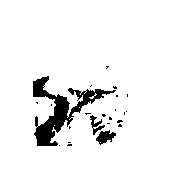

In [38]:
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import numpy as np
import trimesh
import pyrender

# Load the FUZE bottle trimesh and put it in a scene
mesh = pyrender.Mesh.from_trimesh(mesh1)
scene = pyrender.Scene()
scene.add(mesh)

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2)/2
camera_pose = trimesh.transformations.translation_matrix((50,50, 100))
scene.add(camera, pose=camera_pose)

# Set up the light -- a single spot light in the same spot as the camera
light = pyrender.SpotLight(color=[0,255,0], intensity=1.0,
                               innerConeAngle=np.pi/16.0)
scene.add(light, pose=camera_pose)

# Render the scene
r = pyrender.OffscreenRenderer(1080, 960)
color, depth = r.render(scene)

# Show the images
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
# plt.subplot(1,2,2)
# plt.axis('off')
# plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()